**Importing modules**

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re
from abc import ABC, abstractmethod

**Creating the NN object**

In [56]:
class Net(nn.Module):

    def __init__(self, path): # path is the path to the network data
        super(Net, self).__init__()

        network_data = self.get_matrix_data(path)

        self.layers = nn.Sequential()

        for layernumber in network_data.keys():
            if layernumber == -1:
                # final layer
                # should have linear activation function
                self.layers.add_module(f'layer_{layernumber}', self.load_layer(network_data[layernumber]))
                self.layers.add_module(f'activation_{layernumber}', nn.Linear(10, 10, bias=True))
            elif len(network_data[layernumber]) == 4:
                # factorised layer
                # this layer should have a relu activation function
                self.layers.add_module(f'layer_{layernumber}', self.load_factorised_layer(network_data[layernumber]))
                self.layers.add_module(f'activation_{layernumber}', nn.ReLU())
            else:
                # normal layer
                self.layers.add_module(f'layer_{layernumber}', self.load_layer(network_data[layernumber]))
    
    @abstractmethod
    def load_factorised_layer(self, layer_data):
        # load the factorised layer
        # layer_data is a dictionary containing the locations of the layer data
        # layer_data = {'S': S_file, 'b': b_file, 'U': U_file, 'V': V_file}
        S = torch.from_numpy(np.loadtxt(layer_data['S']))
        b = torch.from_numpy(np.loadtxt(layer_data['b']))
        U = torch.from_numpy(np.loadtxt(layer_data['U']))
        V = torch.from_numpy(np.loadtxt(layer_data['V']).T) # The V matrix needs to be transposed

        return nn.Linear(U.shape[1], U.shape[0], bias=True)
    
    @abstractmethod
    def load_layer(self, layer_data):
        # load the layer
        # layer_data is a dictionary containing the locations of the layer data
        # layer_data = {'W': W_file, 'b': b_file}
        W = torch.from_numpy(np.loadtxt(layer_data['W']))
        b = torch.from_numpy(np.loadtxt(layer_data['b']))

        return nn.Linear(W.shape[1], W.shape[0], bias=True)

    @abstractmethod
    def get_matrix_data(self, path):

        network_data = {}

        dir = Path.cwd() / path

        for file in dir.glob('*.txt'):
            split_file = file.stem.split('_')
            try:
                # the final layer has a differnet naming convention, and such a different loading method
                layernumber, filetype = int(split_file[1]), (split_file[-1])
            except:
                filetype = split_file[-1]
                layernumber = -1

            if layernumber in network_data.keys():
                network_data[layernumber][filetype] = file
            else:
                network_data[layernumber] = {filetype: file}
        
        # returns the locations of the network data, to be loaded in the load_layer method
        return network_data

    def forward(self, x):
        x = x.view(-1, 28 * 28) 
        x = self.layers(x) 
        return x

# Initialize the neural network model
net = Net('network_data')

**Get the images**

In [71]:
cwd = Path.cwd()
data_dir = cwd / "data"

def get_mnist():
    return datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

def return_image(image_index, mnist_dataset):
    # Get the image and its corresponding label
    image, label = mnist_dataset[image_index]

    # Now, you have the image as a PyTorch tensor.
    # You can access its data as a matrix using .detach().numpy()
    image_matrix = image[0].detach().numpy()  # Grayscale image, so we select the first channel (index 0)

    return image_matrix.reshape(image_matrix.size), image_matrix, label


**Running the network**

(784,)


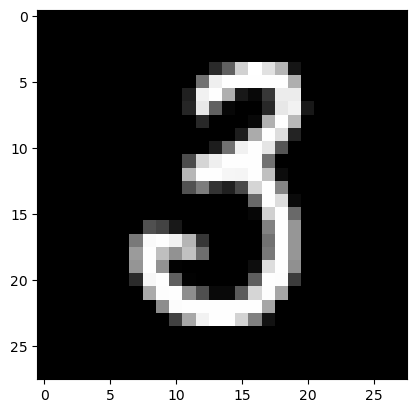

In [80]:
# Choose an index to select one of the images
image_index = 46136
mnist_dataset = get_mnist()

# Get the image and its corresponding label
image, image_matrix, label = return_image(image_index, mnist_dataset)

# get the output of the network
print(image.shape)

# Plot the image
plt.imshow(image_matrix, cmap='gray')

# get the output of the network

#output = net(image)
#output_from_file = net(image_from_file)

In [ ]:
# neural network tester

def test_neural_network(net, mnist_dataset):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in mnist_dataset:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

test_neural_network(net, get_mnist())

Accuracy of the network on the 10000 test images: 91.32333333333334%
